# Fcc-bcc free energies of aluminum through a Bain Transformation

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [31]:
###################################################################
# Plot options
###################################################################

font = {'family' : 'serif',
        'serif'   : 'palatino',
        #'sans-serif'    : 'Computer Modern Sans serif', 
        'style'   : 'normal',
        'variant'   : 'normal',
        'stretch'   : 'normal',
        'weight'   : 'normal',
        'size'   : 20}
plt.rc('font', **font)
plt.rc('text', usetex=True)
plt.rcParams['figure.figsize'] = (15, 6)

###################################################################
# Colors
###################################################################
# Palette 1
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]
for i in range(len(tableau20)):
    r, g, b = tableau20[i]
    tableau20[i] = (r / 255., g / 255., b / 255.)
MarkerSize=20
palette=tableau20

In [3]:
def batch(data,total_batch_num,batch_num):
    if (batch_num<0):
        raise Exception('batch_num must be greater than 0! Start from index 0')
    if (batch_num>(total_batch_num-1)):
        raise Exception('batch_num must be smaller than total_batch_num-1!')
    batch_size=int(data.shape[0]/total_batch_num)
    start=batch_size*batch_num
    end=batch_size*(batch_num+1)
    if (end>data.shape[0]):
        end=data.shape[0]
    return data[start:end]

In [4]:
def freeEnergies(CV,bias,temperature,total_batch_num,CVlimit):
    freeEnergiesStruct=np.zeros([total_batch_num])
    beta=1./(0.00831441001626*temperature)
    for k in range(total_batch_num):
        probLiquid=np.sum(np.exp(beta*batch(bias[CV<=CVlimit],total_batch_num,k)))
        probSolid=np.sum(np.exp(beta*batch(bias[CV>=CVlimit],total_batch_num,k)))
        freeEnergiesStruct[k]=-(1./beta)*np.log(probSolid/probLiquid)
    return freeEnergiesStruct

In [5]:
def autocorr(x):
    result = np.correlate(x-np.mean(x), x-np.mean(x), mode='full')
    return result[int(result.shape[0]/2):]

In [7]:
decorrelatedsamples=20

## Example - 1500 K and 30 GPa

In [8]:
COLVART1500P30=np.genfromtxt("Example/1500K-30GPa/Reweight/COLVARtrim")
cv=COLVART1500P30[:,12]
bias=COLVART1500P30[:,15]
wall1=COLVART1500P30[:,17]
wall2=COLVART1500P30[:,19]
wall3=COLVART1500P30[:,21]
totalBias=bias+wall1+wall2+wall3

CV vs time for four concatenated replicas. The initial equilibration of 10 ns was discarded.

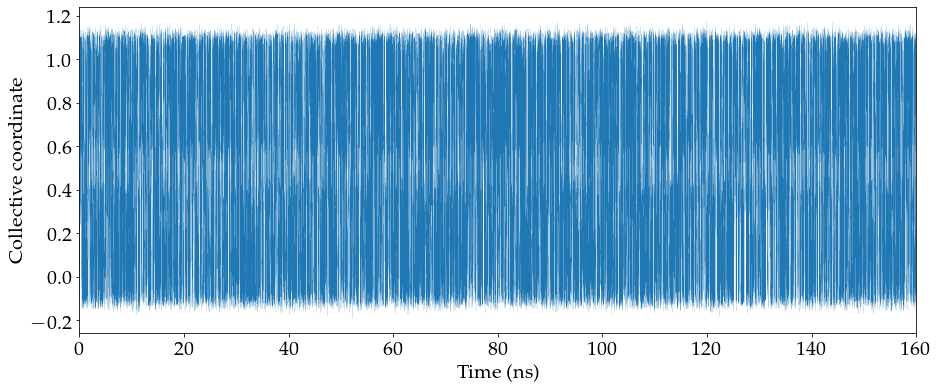

In [32]:
time=np.linspace(0,160,cv.shape[0])
plt.plot(time,cv,linewidth=0.1)

plt.xlabel("Time (ns)")
plt.ylabel("Collective coordinate")

plt.xlim([0,160])

plt.show()

Free energy from reweighting

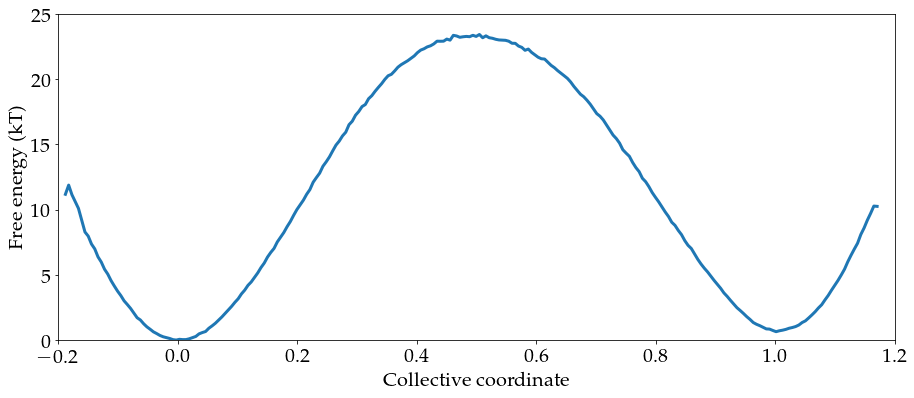

In [43]:
temp=1500 #K
beta=1./(0.0083144100163*temp)
hist, bin_edges = np.histogram(cv,weights=np.exp(beta*(totalBias-np.mean(totalBias))),bins=250)
mybins=(bin_edges[1:]+bin_edges[:-1])/2.
fes=-(1./beta)*np.log(hist)
fes -= np.amin(fes)
fes *= beta
plt.plot(mybins,fes,linewidth=3.0)
plt.xlim([-0.2,1.2])
plt.ylim([0,25])
plt.xlabel("Collective coordinate")
plt.ylabel("Free energy (kT)")
plt.show()

Effective free energy once the bias has converged

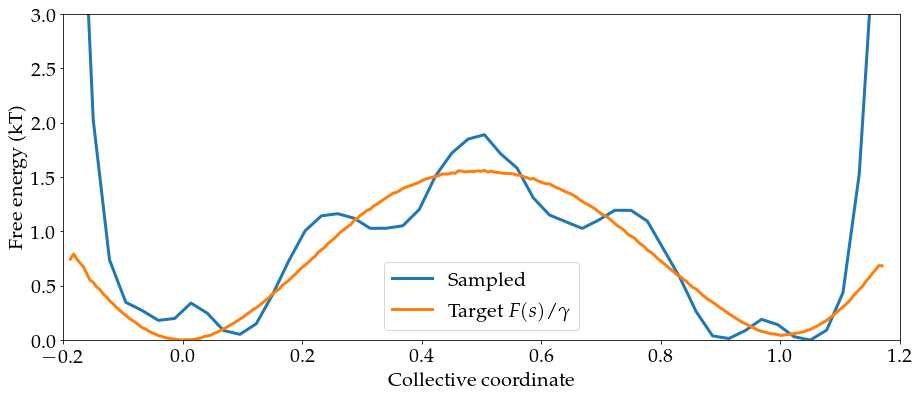

In [45]:
temp=1500 #K
beta=1./(0.0083144100163*temp)
hist2, bin_edges2 = np.histogram(cv,bins=50)
mybins2=(bin_edges2[1:]+bin_edges2[:-1])/2.
fes2=-(1./beta)*np.log(hist2)
fes2 -= np.amin(fes2)
fes2 *= beta
plt.plot(mybins2,fes2,linewidth=3.0,label="Sampled")
plt.plot(mybins,fes/15,linewidth=3.0,label=r"Target $F(s)/\gamma$")
plt.xlim([-0.2,1.2])
plt.ylim([0,3])
plt.xlabel("Collective coordinate")
plt.ylabel("Free energy (kT)")

plt.legend()
plt.show()

Autocorrelation time of the CV

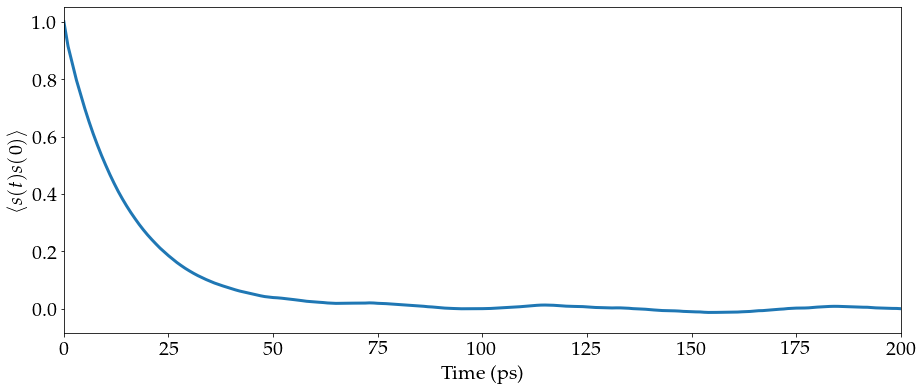

There are roughly 1600 uncorrelated blocks


In [47]:
corr = autocorr(cv)
plt.plot(corr/np.amax(corr),linewidth=3.0)
plt.xlim([0,200])

plt.xlabel("Time (ps)")
plt.ylabel(r"$ \langle s(t) s(0) \rangle $")
plt.show()

tau=100 # ps of correlation time
decorrelatedsamples=int(cv.shape[0]/tau)
print("There are roughly " + str(decorrelatedsamples) + " uncorrelated blocks")

Free energies

In [52]:
decorrelatedsamples=20
freeEnergiesT1500P30=freeEnergies(cv,totalBias,1500,decorrelatedsamples,0.5)

Mean free energy is 0.036394007137529834 kJ/mol/atom


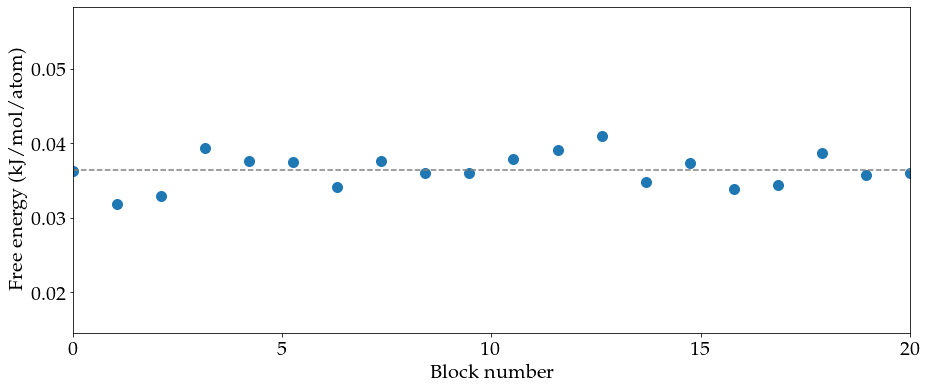

In [76]:
numAtoms=256

plt.scatter(np.linspace(0,decorrelatedsamples,decorrelatedsamples),freeEnergiesT1500P30/numAtoms,s=100)
plt.plot([0,decorrelatedsamples],np.array([1,1])*np.mean(freeEnergiesT1500P30)/numAtoms,'--',color='gray')

plt.xlim([0,20])
plt.xlabel("Block number")
plt.ylabel("Free energy (kJ/mol/atom)")
plt.xticks([0,5,10,15,20])
print("Mean free energy is " + str(np.mean(freeEnergiesT1500P30)/numAtoms) + " kJ/mol/atom")
plt.show()

## All results

In [61]:
refBain=np.genfromtxt("results.txt")
from tabulate import tabulate
table = np.reshape(refBain, (11, 3), 'F')
print(tabulate(table, headers=["Temp (K)","Pressure (GPa)","Free energy (kJ/mol/atom)"],tablefmt='github'))

|   Temp (K) |   Pressure (GPa) |   Free energy (kJ/mol/atom) |
|------------|------------------|-----------------------------|
|       1800 |             27.5 |                  -0.630445  |
|       2000 |             27.5 |                  -0.405847  |
|       2200 |             27.5 |                  -0.10093   |
|       1500 |             30   |                  -0.0360436 |
|       1750 |             30   |                   0.0101844 |
|       1800 |             30   |                   0.0199452 |
|       2000 |             30   |                   0.150058  |
|       2200 |             30   |                   0.360696  |
|       1800 |             32.5 |                   0.829041  |
|       2000 |             32.5 |                   0.864046  |
|       2200 |             32.5 |                   0.908885  |


## Free energy vs temperature and pressure

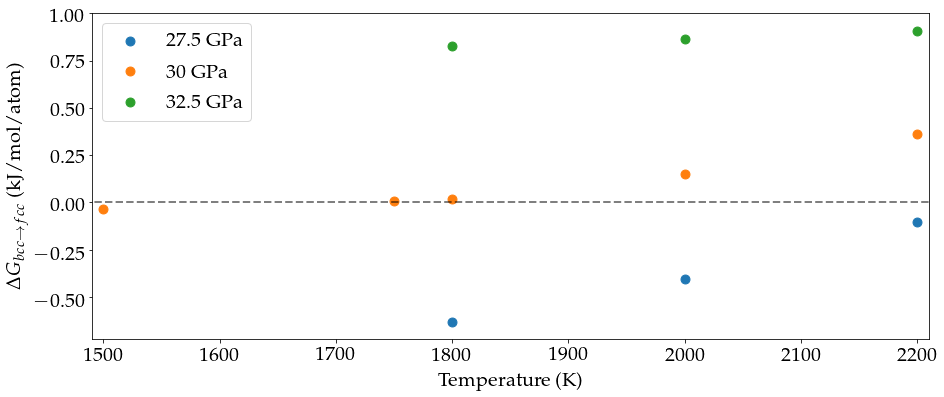

In [66]:
fig, ax1 = plt.subplots()



x=refBain[refBain[:,1]==27.5,0]
means275=refBain[refBain[:,1]==27.5,2]
plt.scatter(x,means275,s=80,label="27.5 GPa")

x=refBain[refBain[:,1]==30,0]
means30=refBain[refBain[:,1]==30,2]
plt.scatter(x,means30,s=80,label="30 GPa")

x=refBain[refBain[:,1]==32.5,0]
means325=refBain[refBain[:,1]==32.5,2]
plt.scatter(x,means325,s=80,label="32.5 GPa")

plt.xlabel("Temperature (K)")
plt.ylabel(r"$\Delta G_{bcc\rightarrow fcc}$ (kJ/mol/atom)")

x=np.linspace(1400,2300,5)
y=x*0.
plt.plot(x,y,'--',linewidth=2,color="black",alpha=0.5)

plt.xlim([1490,2210])
plt.legend()

plt.show()